In [1]:
import torch as th 
import numpy as np
import matplotlib.pyplot as plt

### Toy Data

Simple math expression with variables and their results
```txt
EXPR -> $k - ( k / a - e );k=8.41,e=9.85,a=5.48! 
RES -> [16.73]
```

In [3]:
from simple_expressions import SimpleExpression, expr_vocabulary, PADDING_TOKEN_ID, UNKNOWN_CHAR_ID, START_OF_ANSWER, encode_expression, decode_expression

class ExpSentence(SimpleExpression):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.vocab = expr_vocabulary
        
    def sample(self, batch_size: int):
        expression, target = super().sample(batch_size)
        full_sentence = []
        answer_break_points = []
        for i in range(batch_size):
            full_sentence.append(expression[i]  + target[i])
            answer_break_points.append(len(expression[i]))
        return full_sentence, answer_break_points

    def create_training_batch(self, context_window: int, batch_size: int):
        sentences, break_points = self.sample(batch_size) 

        encoded_sentences = []
        for i in range(len(sentences)):
            # clipping longer strings
            if break_points[i] > context_window:
                clip_size = break_points[i] - context_window
                sentences[i] = sentences[i][clip_size:]
                break_points[i] = context_window
                assert sentences[i][context_window] == START_OF_ANSWER, f'"{sentences[i]}"'
                
            left_pad = context_window - break_points[i]
            sent_enc = []
            for _ in range(left_pad):
                sent_enc.append(PADDING_TOKEN_ID)

            for x in sentences[i]:
                sent_enc.append(self.vocab.get(x,UNKNOWN_CHAR_ID))
            encoded_sentences.append(sent_enc)
        # shift each setences by one after '[', [max_expression_size+1:] is the context window 
        # and '[' will be the first attention query
        batches = []        
        for encoded_sentence in encoded_sentences:
            for i in range(len(encoded_sentence) - context_window-1):
                batches.append(encoded_sentence[i:i+ context_window+2])

        # safety check
        # starts with  '>' '['
        assert batches[0][-2] == self.vocab[START_OF_ANSWER]
        for b in batches:
            assert b[-1] != self.vocab[START_OF_ANSWER], f"{b}"
            
        return th.tensor(batches, dtype=th.long)
                
                
sampler = ExpSentence(3, (1, 3), (-10, 10), 2, 0.5)
batch = sampler.create_training_batch(64, 2)
batch.shape # [Batch, cntxt+1 + 1]

torch.Size([12, 66])

# Additive Attention

Attending to previous tokens using the -1 as query

using the additive attention
$$
\alpha(q,k) = w_v^T tanh(W_q q + W_k k) \in R
$$
and attention pooling
$$
Attention(q,\mathcal{D}) = \sum_{i=1}^m \alpha (q, k_i)v_i,
$$
but v = k.

In [17]:
class AttentionPool(th.nn.Module):
    def __init__(self,input_dim: int, hidden_dim: int):
        super().__init__()

        self.query = th.nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.key = th.nn.Linear(in_features=input_dim, out_features=hidden_dim)

        self.weight = th.nn.Linear(in_features=hidden_dim, out_features=1)

    def forward(self, q: th.Tensor, v: th.Tensor, pad_mask: th.Tensor):
        # q: [B, n]
        # v: [B, m, n] where D: [m, n] 
        query_out = self.query(q).unsqueeze(1) # [B,1,k]
        keys_out = self.key(v) # [B, m, k]

        # additive attention by broad casting
        additive_attention = th.tanh(query_out + keys_out)

        e = self.weight(additive_attention).squeeze(-1) # [B, m]
        # for softmax calculation to ignore the padded fields, we need to set them as -inf
        # https://juditacs.github.io/2018/12/27/masked-attention.html
        e = e.masked_fill(pad_mask,  float('-inf'))

        alpha = th.softmax(e, dim=-1).unsqueeze(-1) # [B, m, 1] 
        attention_pool = (alpha*v).sum(dim=1) # [B, n]
        return attention_pool


with th.no_grad():
    batch = 10
    contxt_window = 32
    embedding_size = 5
    attn_pool = AttentionPool(input_dim=embedding_size, hidden_dim=3)
    # setting right half as valid tokens and left as paddings
    pad_mask = th.zeros(batch, contxt_window)
    pad_mask[:, contxt_window//2:] = 1 
    pad_mask = (pad_mask==0)
    
    que = th.randn(batch, embedding_size)
    val = th.randn(batch, contxt_window, embedding_size)
    out = attn_pool(que, val, pad_mask)
    assert out.shape == (batch, embedding_size)

In [8]:
class ModelWithAttention(th.nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, attention_hidden: int, padding_idx: int):
        super().__init__()
        self._padding_id = padding_idx
        # # initialize embeddings as on hot encoded vector + small noise
        # noisy_onehot = th.eye(vocab_size) + (th.randn(vocab_size, vocab_size) - 0.5) * 0.033
        self.embeddings = th.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim,padding_idx=padding_idx) #.from_pretrained(noisy_onehot, padding_idx=padding_idx)
        
        self.attn1 = AttentionPool(embedding_dim, attention_hidden)
        self.attn2 = AttentionPool(embedding_dim, attention_hidden)
        self.attn3 = AttentionPool(embedding_dim, attention_hidden)

        self.fc = th.nn.Linear(embedding_dim*3, vocab_size)
        
    def forward(self, x: th.Tensor):
        # x: [B, seq]
        x_embd = self.embeddings(x)
        query = x_embd[:, -1]
        values= x_embd[:, :-1]
        pad_mask = (x[:, :-1] == self._padding_id)
        attn1_out = self.attn1(query, values, pad_mask)
        attn2_out = self.attn2(query, values, pad_mask)
        attn3_out = self.attn3(query, values, pad_mask)

        attn_out = th.concat((attn1_out, attn2_out, attn3_out), dim=1)
        return self.fc(attn_out)
        
with th.no_grad():
    model = ModelWithAttention(vocab_size=10, embedding_dim=12,attention_hidden=4, padding_idx=0)
    x = th.randint(0, 10, (8, 32))
    logits = model(x)
    assert logits.shape == (8, 10)

In [9]:
eta = 0.001

embedding_dim = 64
hidden_dim = 128

n_vars = 3
expr_range = (2, 5)
number_range = (-10, 10)
float_round = 2

context_window = 256
epochs = 10
batch_size = 128
batches_per_epoch = 32

sampler = ExpSentence(n_vars, expr_range, number_range, float_round, 0.5)

calc = ModelWithAttention(vocab_size=len(sampler.vocab), embedding_dim=embedding_dim,attention_hidden=hidden_dim, padding_idx=PADDING_TOKEN_ID)

criterion = th.nn.CrossEntropyLoss(ignore_index=PADDING_TOKEN_ID)
optimizer = th.optim.Adam(calc.parameters(), lr=eta)

losses = []
for epoch in range(epochs):
    for i in range(batches_per_epoch):
    
        tgt = sampler.create_training_batch(batch_size, context_window)

        # past sequence, next output
        tgt_input = tgt[:, :-1]  
        tgt_output = tgt[:, -1]

        optimizer.zero_grad()
        logits = calc(tgt_input)
        
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_output
        )

        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        losses.append(loss_val)

        print(f"Epoch {epoch+1} Batch {i+1}: loss = {loss_val:.4f}")

Epoch 1 Batch 1: loss = 3.9791
Epoch 1 Batch 2: loss = 3.9019
Epoch 1 Batch 3: loss = 3.8174
Epoch 1 Batch 4: loss = 3.7335
Epoch 1 Batch 5: loss = 3.6406
Epoch 1 Batch 6: loss = 3.5356
Epoch 1 Batch 7: loss = 3.4204
Epoch 1 Batch 8: loss = 3.3103
Epoch 1 Batch 9: loss = 3.2011
Epoch 1 Batch 10: loss = 3.0870
Epoch 1 Batch 11: loss = 2.9677
Epoch 1 Batch 12: loss = 2.8717
Epoch 1 Batch 13: loss = 2.7959
Epoch 1 Batch 14: loss = 2.7258
Epoch 1 Batch 15: loss = 2.6613
Epoch 1 Batch 16: loss = 2.6076
Epoch 1 Batch 17: loss = 2.5750
Epoch 1 Batch 18: loss = 2.5390
Epoch 1 Batch 19: loss = 2.5178
Epoch 1 Batch 20: loss = 2.4987
Epoch 1 Batch 21: loss = 2.4954
Epoch 1 Batch 22: loss = 2.4887
Epoch 1 Batch 23: loss = 2.4944
Epoch 1 Batch 24: loss = 2.4848
Epoch 1 Batch 25: loss = 2.4820
Epoch 1 Batch 26: loss = 2.4759
Epoch 1 Batch 27: loss = 2.4545
Epoch 1 Batch 28: loss = 2.4574
Epoch 1 Batch 29: loss = 2.4682
Epoch 1 Batch 30: loss = 2.4633
Epoch 1 Batch 31: loss = 2.4488
Epoch 1 Batch 32:

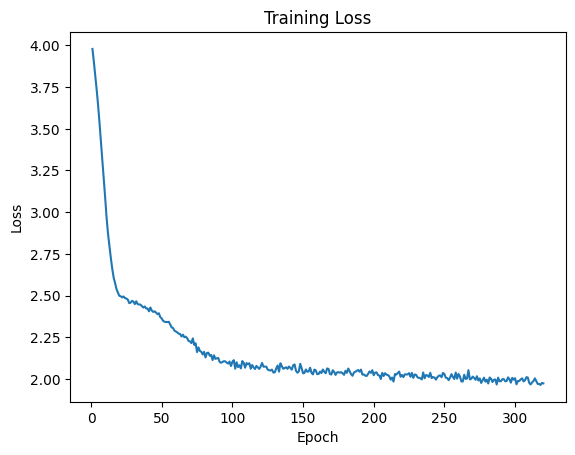

In [10]:
updates = list(range(1, len(losses)+1))
plt.figure()
plt.plot(updates, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [13]:
def sample(
    calc,
    expr: str,
    max_len: int = 10,
    greedy: bool = True,
):
    expr_len = len(expr)

    expr = [encode_expression(expr)]
    expr[0].append( sampler.vocab[START_OF_ANSWER] )

    with th.no_grad():
          
        for _ in range(max_len):
            encodings = th.tensor(expr)
            logits = calc(encodings)
            # logits: [B, 1, vocab]
            logits = logits.squeeze(1)
    
            if greedy:
                next_token = logits.argmax(dim=-1)
            else:
                probs = th.softmax(logits, dim=-1)
                next_token = th.multinomial(probs, num_samples=1).squeeze(1)
    
            expr[0].append(next_token.item())
    
            # early stop if all finished
            if (next_token == sampler.vocab[']']).all():
                break
    
    return expr[0][expr_len:]

In [23]:
for expr_sen, bp in zip(*sampler.sample(10)):
    expr, ans = expr_sen[:bp], expr_sen[bp:]
    result = sample(calc, expr, greedy=False)
    predict = ''.join(decode_expression(result))
    print(f"{expr} = {ans}\nCalc = {predict}")

$y / ( c ) - r * y;y=7.63,r=7.73,c=2.56! = [-56.0]
Calc = [21]
$r / ( e - ( r ) + ( x / x ) );r=-5.86,e=8.73,x=-6.8! = [-0.38]
Calc = [0.3.8]
$v - v / ( a ) - v / t;a=7.32,t=-1.87,v=-4.41! = [-6.17]
Calc = [1]
$( e / ( o ) + o * e );e=-7.16,o=-4.37! = [32.93]
Calc = [8.7]
$z * ( u - ( w + ( w ) * u ) );z=-2.11,u=6.23,w=4.37! = [53.52]
Calc = [69.9]
$r / l * b - l - r;l=-6.97,b=-3.41,r=-4.83! = [9.44]
Calc = [-07]
$( k ) + h * u * u;k=-3.57,h=3.21,u=-0.75! = [-1.76]
Calc = [1]
$( z ) - i / w * z / w;i=1.97,z=8.83,w=-9.85! = [8.65]
Calc = [2.67261268
$h - z / v / z;h=-9.93,z=-1.56,v=-6.33! = [-9.77]
Calc = [0.86.8]
$( s ) * m + u;m=-6.15,s=-5.17,u=0.14! = [31.94]
Calc = [-5.1854853
